## Print the parameters of the device

In [222]:
import json
import pandas as pd
from IPython.display import display

with open("cr_params.json", "r") as f:
    params = json.load(f)

fun5_right = params["FUN5_Right"]

fun5_right = params["UMA5"]

# Device parameters from JSON
json_data = {
    "Device": ["Fluxonium", "Transmon", "Coupling"],
    "EJ": [fun5_right['fluxonium']['EJ'], fun5_right['transmon']['EJ'], ""],
    "EC": [fun5_right['fluxonium']['EC'], fun5_right['transmon']['EC'], ""],
    "EL": [fun5_right['fluxonium']['EL'], "", ""],
    "Jc": ["", "", fun5_right['Jc']]
}

df_json = pd.DataFrame(json_data)

# Experimental parameters (from image)
exp_param = [
    "Cavity LO Freq.", "Kappa_c", "Qubit 0-1", "T1", "FT1", "T2", "T2E", "Qubit 1-2", "Temperature", "Chi",
    "Anharmonicity", "Ec", "EJ", "Jc", "Cavity Freq.", "Kappa_c", "Flux period", "Half flux point",
    "Qubit 0-1", "EJ", "EC", "EL", "Temp.", "Half flux T1", "FT1", "Half flux T2", "T2E", "Qubit 1-2", "ZZ"
]
transmon_vals = [
    "7.379 GHz", "3.938", "", "~30 (~50 after stark shift)", "~20", "~12", "~30", "3720", "2.2%", "218 MHz",
    "218 MHz", "0.19", "11.3", "~0.24"
] + [""] * (len(exp_param) - 14)
fluxonium_vals = [
    "", "", "", "", "", "", "", "", "", "", "", "", "", "",
    "6.9 GHz", "1.63 mA", "1.63 mA", "164.5 MHz", "3.743", "3.743", "0.918", "0.360", "~170-180", "~60", "~60", "~70", "~70", "3.542 GHz", "0.65 MHz"
]

exp_data = {
    "Parameter": exp_param,
    "Transmon": transmon_vals,
    "Fluxonium": fluxonium_vals
}

df_exp = pd.DataFrame(exp_data)

print("FUN5_Right Device Parameters (from JSON):")
display(df_json)

print("FUN5_Right Device Experimental Parameters:")
display(df_exp)

FUN5_Right Device Parameters (from JSON):


,Device,EJ,EC,EL,Jc
0,Fluxonium,4.1933,1.0617,0.9336,
1,Transmon,19.98,0.1845,,
2,Coupling,,,,0.0222


FUN5_Right Device Experimental Parameters:


,Parameter,Transmon,Fluxonium
0,Cavity LO Freq.,7.379 GHz,
1,Kappa_c,3.938,
2,Qubit 0-1,,
3,T1,~30 (~50 after stark shift),
4,FT1,~20,
5,T2,~12,
6,T2E,~30,
7,Qubit 1-2,3720,
8,Temperature,2.2%,
9,Chi,218 MHz,


### Basic simulated values

#### Matrix elements

#### Following Nick's method of calculating Matrix element

In [277]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
FT_Device = params["UMA5"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

In [281]:
n_Tr_full
n_Fl1_full
dressed_epairs[1, 1][1]  # (E_01, |01> dressed state)

n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[2, 0][1])

(-6.406994361538371e-16-0.5715381497291304j)

In [286]:
0.00735/(.106-.017)



0.08258426966292134

In [280]:
n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
n_T_00_01 = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_T_10_11 = n_Tr_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
print("-i * <00|n_Fl1|01> =", -1j * n_F_00_01)
print("-i * <10|n_Fl1|11> =", -1j * n_F_10_11)
print("-i * <00|n_Tr|01> =", -1j * n_T_00_01)
print("-i * <10|n_Tr|11> =", -1j * n_T_10_11)

-i * <00|n_Fl1|01> = (-1.341050525096894e-15-0.003385411170724313j)
-i * <10|n_Fl1|11> = (2.4630107519420133e-17+0.0044607446469634j)
-i * <00|n_Tr|01> = (-2.3740343101389472e-17+1.3320512327366125j)
-i * <10|n_Tr|11> = (-6.204467283277893e-16+1.3319899924365293j)


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

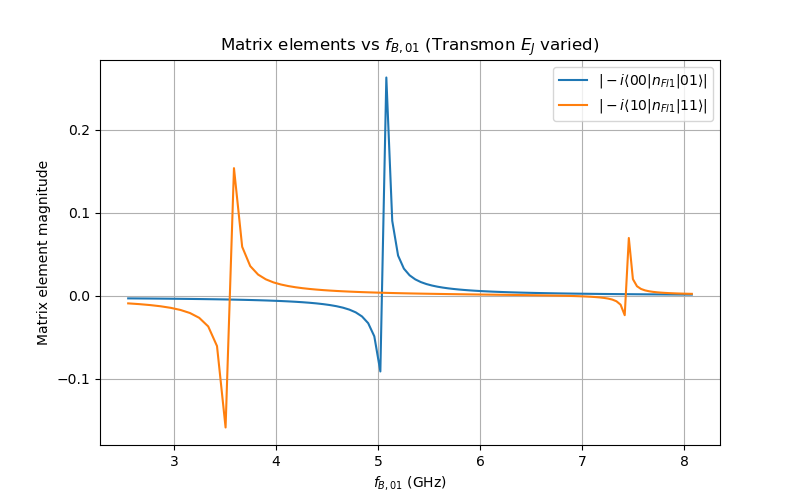

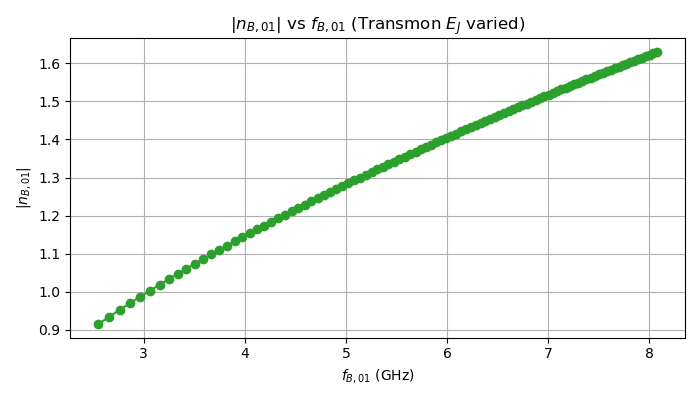

In [81]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]

k = 120
trunc = 6

EJ_range = np.linspace(5, 45, 100)  # EJ values for Transmon (in GHz)
f_B_01_list = []
n_F_00_01_list = []
n_F_10_11_list = []
n_B_01_list = []

for EJ_val in EJ_range:
    # Update Transmon EJ
    Tr = scq.Transmon(
        EJ=EJ_val,
        EC=FT_Device['transmon']['EC'],
        ng=0,
        ncut=k,
        truncated_dim=trunc
    )
    Fl1 = scq.Fluxonium(
        EJ=FT_Device['fluxonium']['EJ'],
        EC=FT_Device['fluxonium']['EC'],
        EL=FT_Device['fluxonium']['EL'],
        flux=0.5,
        cutoff=k,
        truncated_dim=trunc
    )
    J1T = FT_Device['Jc']

    # Build coupled system
    full_system = scq.HilbertSpace([Fl1, Tr])
    full_system.add_interaction(
        g=J1T,
        op1=(Fl1.n_operator(), Fl1),
        op2=(Tr.n_operator(), Tr)
    )
    full_system.generate_bare_esys()
    full_system.generate_lookup()

    H_full = 2 * np.pi * full_system.hamiltonian()
    evals, ekets = H_full.eigenstates()

    n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
    n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

    def get_dressed_epairs(evals, ekets):
        dressed_epairs = np.empty((5, 5), dtype=object)
        for i in range(4):
            for j in range(4):
                index = full_system.dressed_index((i, j))
                ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
                np.angle(ztemp)
                dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
        return dressed_epairs

    dressed_epairs = get_dressed_epairs(evals, ekets)

    # Calculate matrix elements
    n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
    n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])

    # Calculate f_B_01 (bare Transmon 0-1 transition)
    bare_states_b = Tr.eigenvals() - Tr.eigenvals()[0]
    f_B_01 = bare_states_b[1] - bare_states_b[0]
    n_b_bare = qt.Qobj(Tr.n_operator(energy_esys=True)[:5, :5])
    n_B_01 = n_b_bare[0, 1]

    f_B_01_list.append(f_B_01)
    n_B_01_list.append(np.abs(n_B_01))
    n_F_00_01_list.append((n_F_00_01) / (n_B_01))
    n_F_10_11_list.append((n_F_10_11) / (n_B_01))

plt.figure(figsize=(8, 5))
plt.plot(f_B_01_list, n_F_00_01_list, label=r'$|-i \langle 00|n_{Fl1}|01\rangle|$')
plt.plot(f_B_01_list, n_F_10_11_list, label=r'$|-i \langle 10|n_{Fl1}|11\rangle|$')
plt.xlabel(r'$f_{B,01}$ (GHz)')
plt.ylabel('Matrix element magnitude')
plt.title(r'Matrix elements vs $f_{B,01}$ (Transmon $E_J$ varied)')
plt.legend()
plt.grid(True)
plt.show()

# Additional plot: n_B_01 vs f_B_01
plt.figure(figsize=(7, 4))
plt.plot(f_B_01_list, n_B_01_list, marker='o', linestyle='-', color='tab:green')
plt.xlabel(r'$f_{B,01}$ (GHz)')
plt.ylabel(r'$|n_{B,01}|$')
plt.title(r'$|n_{B,01}|$ vs $f_{B,01}$ (Transmon $E_J$ varied)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### CR Matrix element analytical expression. 

$$
\langle 00|\hat{n}_A|01\rangle \approx -2i \frac{J_C}{h} n_{01}^B \left[ \frac{(n_{01}^A)^2 f_{01}^A}{(f_{01}^A)^2 - (f_{01}^B)^2} + \frac{(n_{03}^A)^2 f_{03}^A}{(f_{03}^A)^2 - (f_{01}^B)^2} \right]
$$

$$
\qquad = \frac{-2i}{h} n_{01}^B \times \text{‘transmission coefficient when control is in 0’}
$$


$$
\langle 10|\hat{n}_A|11\rangle \approx 2i \frac{J_C}{h} n_{01}^B \left[ \frac{(n_{01}^A)^2 f_{01}^A}{(f_{01}^A)^2 - (f_{01}^B)^2} - \frac{(n_{12}^A)^2 f_{12}^A}{(f_{12}^A)^2 - (f_{01}^B)^2} \right]
$$

$$
\qquad = \frac{-2i}{h} n_{01}^B \times \text{‘transmission coefficient when control is in 1’}
$$


In [143]:
def calc_matrix_elements_analytical(
    Jc, n_A_01, n_A_03, n_A_12, f_A_01, f_A_03, f_A_12, EJ, EC, h=1
):
    """
    Calculate -i*<00|n_A|01>/n_B_01 and -i*<10|n_A|11>/n_B_01 using the analytical formula.
    n_B_01 and f_B_01 are computed internally from Transmon parameters.

    Args:
        Jc: coupling strength (float)
        n_A_01: <0|n|1> for A (float)
        n_A_03: <0|n|3> for A (float)
        n_A_12: <1|n|2> for A (float)
        f_A_01: f_01^A (float)
        f_A_03: f_03^A (float)
        f_A_12: f_12^A (float)
        EJ: Transmon EJ (float)
        EC: Transmon EC (float)
        h: Planck constant (float, default 1)

    Returns:
        (analytical_00_01, analytical_10_11, n_B_01, f_B_01)
    """
    # Calculate n_B_01 and f_B_01 from Transmon
    qbtb = scq.Transmon(
        EJ=EJ,
        EC=EC,
        ng=0,
        ncut=110,
        truncated_dim=20
    )
    n_b_bare = qt.Qobj(qbtb.n_operator(energy_esys=True)[:5, :5])
    n_B_01 = n_b_bare[0, 1]
    bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
    f_B_01 = bare_states_b[1] - bare_states_b[0]

    # Analytical expressions
    term1_00_01 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2_00_01 = (n_A_03**2 * f_A_03) / (f_A_03**2 - f_B_01**2)
    val_00_01 = -2j * Jc / h * (term1_00_01 + term2_00_01) * np.abs(n_B_01)

    term1_10_11 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2_10_11 = (n_A_12**2 * f_A_12) / (f_A_12**2 - f_B_01**2)
    val_10_11 = 2j * Jc / h * (term1_10_11 - term2_10_11) * np.abs(n_B_01)

    return ( val_00_01,  val_10_11, n_B_01, f_B_01)

In [256]:
def calc_matrix_elements_numerical(
    fluxonium_params, transmon_params, Jc, trunc=6, k=120
):
    """
    Calculate -i*<00|n_Fl1|01>/n_B_01 and -i*<10|n_Fl1|11>/n_B_01 numerically
    using scqubits diagonalization.

    Args:
        fluxonium_params: dict with keys 'EJ', 'EC', 'EL'
        transmon_params: dict with keys 'EJ', 'EC'
        Jc: coupling strength (float)
        trunc: truncated_dim for both qubits (int)
        k: cutoff/ncut for both qubits (int)

    Returns:
        (n_00_01, n_10_11, f_B_01)
    """
    Fl1 = scq.Fluxonium(
        EJ=fluxonium_params['EJ'],
        EC=fluxonium_params['EC'],
        EL=fluxonium_params['EL'],
        flux=0.5,
        cutoff=k,
        truncated_dim=trunc
    )
    Tr = scq.Transmon(
        EJ=transmon_params['EJ'],
        EC=transmon_params['EC'],
        ng=0,
        ncut=k,
        truncated_dim=trunc
    )

    # Build coupled system
    full_system = scq.HilbertSpace([Fl1, Tr])
    full_system.add_interaction(
        g=Jc,
        op1=(Fl1.n_operator(), Fl1),
        op2=(Tr.n_operator(), Tr)
    )
    full_system.generate_bare_esys()
    full_system.generate_lookup()

    H_full = 2 * np.pi * full_system.hamiltonian()
    evals, ekets = H_full.eigenstates()

    n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])

    def get_dressed_epairs(evals, ekets):
        dressed_epairs = np.empty((5, 5), dtype=object)
        for i in range(4):
            for j in range(4):
                index = full_system.dressed_index((i, j))
                ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
                dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
        return dressed_epairs

    dressed_epairs = get_dressed_epairs(evals, ekets)

    n_b_bare = qt.Qobj(Tr.n_operator(energy_esys=True)[:5, :5])
    n_B_01 = n_b_bare[0, 1]

    n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
    n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])

    bare_states_b = Tr.eigenvals() - Tr.eigenvals()[0]
    f_B_01 = bare_states_b[1] - bare_states_b[0]

    # return (-1j * n_F_00_01 * np.abs(n_B_01) / n_B_01,-1j* n_F_10_11 * np.abs(n_B_01) / n_B_01, f_B_01)
    return (-1j * n_F_00_01/ n_B_01 * np.abs(n_B_01),-1j* n_F_10_11 / n_B_01 * np.abs(n_B_01), f_B_01)


In [257]:
# Example usage of both functions for the same set of device parameters

import scqubits as scq
import qutip as qt
import numpy as np
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
# FT_Device = params["FUN5_Right"]
# FT_Device = params["UMA5"]
FT_Device = params["FTF_FUN10_Type_3"]

# Fluxonium and Transmon parameters
fluxonium_params = FT_Device['fluxonium']
transmon_params = FT_Device['transmon']
Jc = FT_Device['Jc']

# Get bare matrix elements and frequencies for analytical function
qbta = scq.Fluxonium(
    EC=fluxonium_params['EC'],
    EJ=fluxonium_params['EJ'],
    EL=fluxonium_params['EL'],
    flux=0.5,
    cutoff=110,
    truncated_dim=20,
)
n_a_bare = qt.Qobj(qbta.n_operator(energy_esys=True)[:5, :5])
n_A_01 = n_a_bare[0, 1]
n_A_12 = n_a_bare[1, 2]
n_A_03 = n_a_bare[0, 3]
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
f_A_01 = bare_states_a[1] - bare_states_a[0]
f_A_03 = bare_states_a[3] - bare_states_a[0]
f_A_12 = bare_states_a[2] - bare_states_a[1]

# Choose a test EJ, EC for the transmon (can use from FT_Device or sweep)
EJ = transmon_params['EJ']
EC = transmon_params['EC']

# Analytical calculation (n_B_01 and f_B_01 are calculated inside)
analytical_00_01, analytical_10_11, n_B_01, f_B_01 = calc_matrix_elements_analytical(
    Jc, n_A_01, n_A_03, n_A_12, f_A_01, f_A_03, f_A_12, EJ, EC
)

# Numerical calculation (pass all parameters explicitly)
numerical_00_01, numerical_10_11, f_B_01_num = calc_matrix_elements_numerical(
    fluxonium_params, {'EJ': EJ, 'EC': EC}, Jc, trunc=6, k=120
)

print("Analytical -i<00|n_A|01>/n_B_01:", -1j*analytical_00_01)
print("Analytical -i<10|n_A|11>/n_B_01:", -1j*analytical_10_11)
print("Numerical  -i<00|n_A|01>/n_B_01:", -1j*numerical_00_01)
print("Numerical  -i<10|n_A|11>/n_B_01:", -1j*numerical_10_11)
print("n_B_01 (from analytical):", n_B_01)
print("f_B_01 (from analytical):", f_B_01)
print("f_B_01 (from numerical):", f_B_01_num)

Analytical -i<00|n_A|01>/n_B_01: (0.002455776854940599-0j)
Analytical -i<10|n_A|11>/n_B_01: (0.004032560150519465-0j)
Numerical  -i<00|n_A|01>/n_B_01: (0.002460106106878119-2.2512192080700717e-17j)
Numerical  -i<10|n_A|11>/n_B_01: (0.004338160202602301-1.287078278274979e-17j)
n_B_01 (from analytical): (1.3568947231328006+0j)
f_B_01 (from analytical): 1.266939636276628
f_B_01 (from numerical): 1.2669396362770309


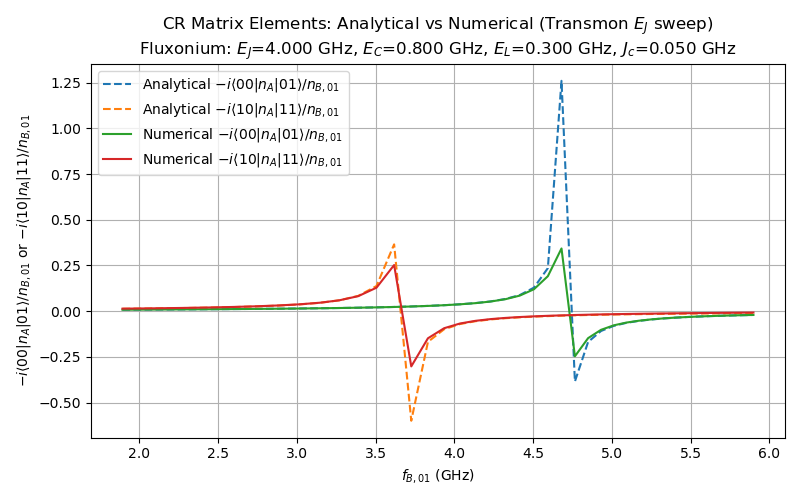

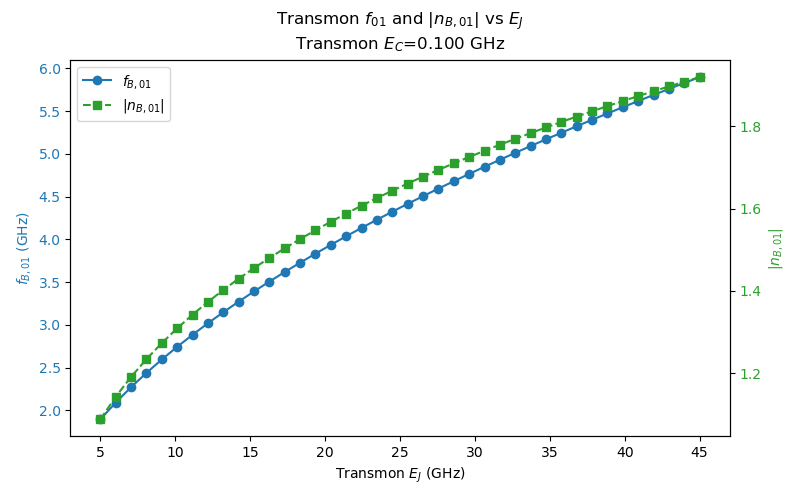

In [291]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
FT_Device = params["UMA5"]  # Uncomment if using UMA5 parameters
FT_Device = params["FTF_FUN10_Type_3"]
FT_Device = params["FT_FUN13"]

# Fluxonium parameters (fixed)
fluxonium_params = FT_Device['fluxonium']
Jc = FT_Device['Jc']

# Get bare matrix elements and frequencies for analytical function (fixed Fluxonium)
qbta = scq.Fluxonium(
    EC=fluxonium_params['EC'],
    EJ=fluxonium_params['EJ'],
    EL=fluxonium_params['EL'],
    flux=0.5,
    cutoff=110,
    truncated_dim=20,
)
n_a_bare = qt.Qobj(qbta.n_operator(energy_esys=True)[:5, :5])
n_A_01 = n_a_bare[0, 1]
n_A_12 = n_a_bare[1, 2]
n_A_03 = n_a_bare[0, 3]
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
f_A_01 = bare_states_a[1] - bare_states_a[0]
f_A_03 = bare_states_a[3] - bare_states_a[0]
f_A_12 = bare_states_a[2] - bare_states_a[1]

# Sweep Transmon EJ
EJ_range = np.linspace(5, 45, 40)
f_B_01_list = []
analytical_00_01_list = []
analytical_10_11_list = []
numerical_00_01_list = []
numerical_10_11_list = []
n_B_01_sweep_list = []

for EJ in EJ_range:
    EC = FT_Device['transmon']['EC']
    # Analytical calculation (n_B_01 and f_B_01 are calculated inside)
    analytical_00_01, analytical_10_11, n_B_01, f_B_01 = calc_matrix_elements_analytical(
        Jc, n_A_01, n_A_03, n_A_12, f_A_01, f_A_03, f_A_12, EJ, EC
    )
    analytical_00_01_list.append(-1j*analytical_00_01)
    analytical_10_11_list.append(-1j*analytical_10_11)
    f_B_01_list.append(f_B_01)

    # Numerical calculation (pass all parameters explicitly)
    numerical_00_01, numerical_10_11, f_B_01_num = calc_matrix_elements_numerical(
        fluxonium_params, {'EJ': EJ, 'EC': EC}, Jc, trunc=6, k=120
    )
    numerical_00_01_list.append(-1j*numerical_00_01)
    numerical_10_11_list.append(-1j*numerical_10_11)
    n_B_01_sweep_list.append(np.abs(n_B_01)) 

plt.figure(figsize=(8, 5))
plt.plot(f_B_01_list, analytical_00_01_list, '--', label='Analytical $-i\\langle 00|n_A|01\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, analytical_10_11_list, '--', label='Analytical $-i\\langle 10|n_A|11\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, numerical_00_01_list, label='Numerical $-i\\langle 00|n_A|01\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, numerical_10_11_list, label='Numerical $-i\\langle 10|n_A|11\\rangle/n_{B,01}$')
plt.xlabel(r'$f_{B,01}$ (GHz)')
plt.ylabel(r'$-i\langle 00|n_A|01\rangle / n_{B,01}$ or $-i\langle 10|n_A|11\rangle / n_{B,01}$')
# plt.ylim(-0.2, 0.2)
# plt.title('CR Matrix Elements: Analytical vs Numerical (Transmon $E_J$ sweep)')
# Add Fluxonium and coupling parameters as fixed values in the title
plt.title(
    'CR Matrix Elements: Analytical vs Numerical (Transmon $E_J$ sweep)\n'
    + f'Fluxonium: $E_J$={fluxonium_params["EJ"]:.3f} GHz, '
      f'$E_C$={fluxonium_params["EC"]:.3f} GHz, '
      f'$E_L$={fluxonium_params["EL"]:.3f} GHz, '
      f'$J_c$={Jc:.3f} GHz'
)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel(r'Transmon $E_J$ (GHz)')
ax1.set_ylabel(r'$f_{B,01}$ (GHz)', color=color1)
line1, = ax1.plot(EJ_range, f_B_01_list, marker='o', linestyle='-', color=color1, label=r'$f_{B,01}$')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel(r'$|n_{B,01}|$', color=color2)
line2, = ax2.plot(EJ_range, n_B_01_sweep_list, marker='s', linestyle='--', color=color2, label=r'$|n_{B,01}|$')
ax2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

fig.suptitle(
    r'Transmon $f_{01}$ and $|n_{B,01}|$ vs $E_J$' + '\n'
    + 
      f'Transmon $E_C$={FT_Device["transmon"]["EC"]:.3f} GHz'
)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

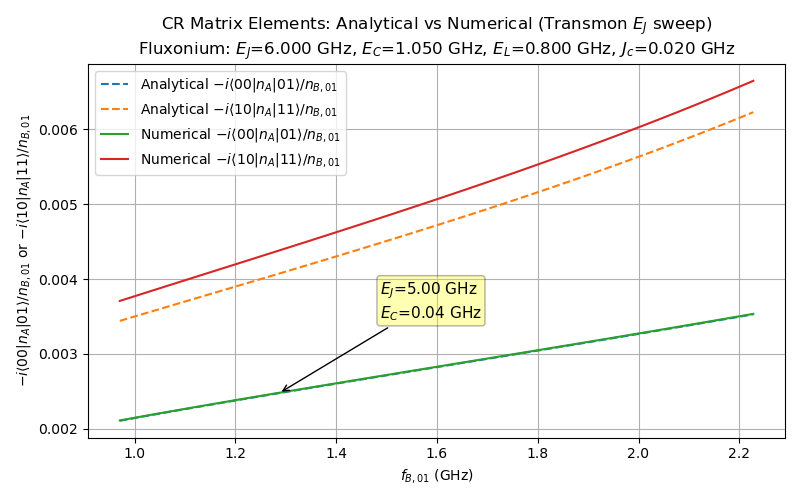

In [265]:
# Find the index in EJ_range closest to the JSON value
EJ_json = FT_Device['transmon']['EJ']
EC_json = FT_Device['transmon']['EC']

# Calculate f_B_01 for the JSON parameters
qbtb_json = scq.Transmon(EJ=EJ_json, EC=EC_json, ng=0, ncut=110, truncated_dim=20)
bare_states_b_json = qbtb_json.eigenvals() - qbtb_json.eigenvals()[0]
f_B_01_json = bare_states_b_json[1] - bare_states_b_json[0]

# Find the closest f_B_01 in your sweep
idx_json = (np.abs(np.array(f_B_01_list) - f_B_01_json)).argmin()
x_json = f_B_01_list[idx_json]
y_json = analytical_00_01_list[idx_json]

plt.figure(figsize=(8, 5))
plt.plot(f_B_01_list, analytical_00_01_list, '--', label='Analytical $-i\\langle 00|n_A|01\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, analytical_10_11_list, '--', label='Analytical $-i\\langle 10|n_A|11\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, numerical_00_01_list, label='Numerical $-i\\langle 00|n_A|01\\rangle/n_{B,01}$')
plt.plot(f_B_01_list, numerical_10_11_list, label='Numerical $-i\\langle 10|n_A|11\\rangle/n_{B,01}$')
plt.xlabel(r'$f_{B,01}$ (GHz)')
plt.ylabel(r'$-i\langle 00|n_A|01\rangle / n_{B,01}$ or $-i\langle 10|n_A|11\rangle / n_{B,01}$')
# plt.ylim(-0.2, 0.2)
plt.title(
    'CR Matrix Elements: Analytical vs Numerical (Transmon $E_J$ sweep)\n'
    + f'Fluxonium: $E_J$={fluxonium_params["EJ"]:.3f} GHz, '
      f'$E_C$={fluxonium_params["EC"]:.3f} GHz, '
      f'$E_L$={fluxonium_params["EL"]:.3f} GHz, '
      f'$J_c$={Jc:.3f} GHz'
)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the JSON parameter location
plt.annotate(
    f'$E_J$={EJ_json:.2f} GHz\n$E_C$={EC_json:.2f} GHz',
    xy=(x_json, y_json),
    xytext=(x_json+0.2, y_json+0.001),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.2", fc="yellow", alpha=0.3)
)

plt.show()

## Now that I have a proper way to calculate numerically the matrix element of for a set of parameters. do the advanced calcualtions for both UMA5 and FUN5 devcie

Drive amplitude f (MHz):  1055.98975689665
-i * <10|n_Fl1|20> = (-1.3305559956952357e-16+0.548098185607148j)
-i * <00|n_Fl1|01> = 0.0062833398591831255
-i * <10|n_Fl1|11> = -0.01914519324041758
-i * <00|n_Tr|01> = -1.1388137597044103
-i * <10|n_Tr|11> = -1.137985178072858


 /var/folders/r1/k579s3gx3wl29l9z816msv5c0000gn/T/ipykernel_56378/3780651855.py: 115

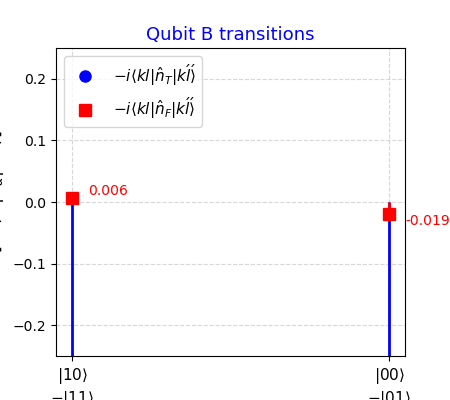

In [301]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
# FT_Device = params["UMA5"]
# FT_Device = params["FTF_FUN10_Type_3"]

k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

bare_states_a = Fl1.eigenvals()-Fl1.eigenvals()[0]
bare_states_b = Tr.eigenvals()-Tr.eigenvals()[0]

lambda_ = 0.02
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (np.abs(n_a_bare[0][1]))  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
n_T_00_01 = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_T_10_11 = n_Tr_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
n_F_10_20 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[2, 0][1])
print("-i * <10|n_Fl1|20> =", n_F_10_20)



values_a = [(n_F_00_01.real), (n_F_10_11.real)]
values_b = [(n_T_00_01.real), (n_T_10_11.real)]
print("-i * <00|n_Fl1|01> =", values_a[0])
print("-i * <10|n_Fl1|11> =", values_a[1])
print("-i * <00|n_Tr|01> =", values_b[0])
print("-i * <10|n_Tr|11> =", values_b[1])

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_T|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_F|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.25, 0.25)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$\mathrm{Im}[-i\langle kl|\hat{n}_\alpha|k'l'\rangle]$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [267]:
bare_states_a = Fl1.eigenvals()-Fl1.eigenvals()[0]
bare_states_b = Tr.eigenvals()-Tr.eigenvals()[0]

lambda_ = 0.02
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (np.abs(n_a_bare[0][1]))  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz) for $\lambda=0.02$: ", f)



Drive amplitude f (MHz) for $\lambda=0.02$:  222.0477120557421


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

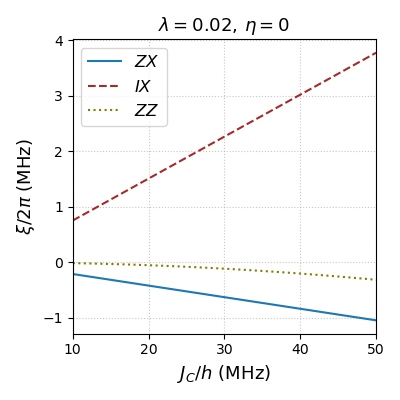

In [272]:
# Here changed the sign on <00|n_A|01>  and multiplied by -1. to match the paper values. why?
  # Match the paper convention
# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.05, 50)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []

for Jc in Jc_values:
    J1T = Jc#FT_Device['Jc']

    full_system = scq.HilbertSpace([Fl1, Tr])
    full_system.add_interaction(
        g=J1T,
        op1=(Fl1.n_operator(), Fl1),
        op2=(Tr.n_operator(), Tr)
    )
    full_system.generate_bare_esys()
    full_system.generate_lookup()

    H_full = 2 * np.pi * full_system.hamiltonian()
    evals, ekets = H_full.eigenstates()

    n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
    n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

    def get_dressed_epairs(evals, ekets):
        dressed_epairs = np.empty((5, 5), dtype=object)
        for i in range(4):
            for j in range(4):
                index = full_system.dressed_index((i, j))
                ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
                np.angle(ztemp)
                dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
        return dressed_epairs

    dressed_epairs = get_dressed_epairs(evals, ekets)

    n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
    n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
    n_T_00_01 = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
    n_T_10_11 = n_Tr_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])

    def get_idx(state_tuple):
        return full_system.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Transition frequencies
    evals = full_system["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])

    # Effective Hamiltonian coefficients (eta=0)
    xi_ZX = (f * (n_F_00_01 - n_F_10_11))
    xi_IX = (f * (n_F_00_01 + n_F_10_11))
    xi_ZZ = (w_10_11 - w_00_01)*1e3

    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZZ_list.append((xi_ZZ))



# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,\eta=0$', fontsize=13)
plt.xlim(10, 50)
# plt.ylim(-100, 100)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

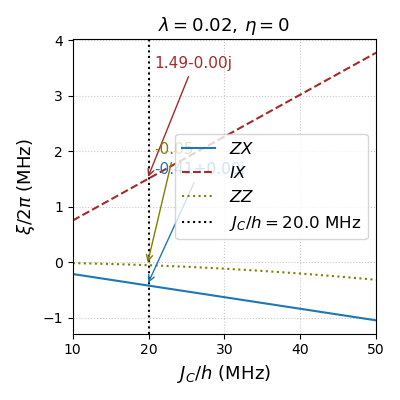

In [275]:
# ...existing code...

plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')

# Add vertical line at Jc/h = 22 MHz
jc_target = FT_Device['Jc'] *1e3 # MHz
plt.axvline(jc_target, color='k', linestyle=':', linewidth=1.5, label=r'$J_C/h= %.1f$ MHz' % jc_target)

# Find the closest index to Jc/h = 22 MHz
idx_22 = (np.abs(Jc_values * 1e3 - jc_target)).argmin()
x_22 = Jc_values[idx_22] * 1e3

# Get the three values at this point
y_zx = xi_ZX_list[idx_22]
y_ix = xi_IX_list[idx_22]
y_zz = xi_ZZ_list[idx_22]

# Annotate the intersection points
plt.annotate(f'{y_zx:.2f}', xy=(x_22, y_zx), xytext=(x_22+1, y_zx+2),
             arrowprops=dict(arrowstyle='->', color='C0'), color='C0', fontsize=11)
plt.annotate(f'{y_ix:.2f}', xy=(x_22, y_ix), xytext=(x_22+1, y_ix+2),
             arrowprops=dict(arrowstyle='->', color='brown'), color='brown', fontsize=11)
plt.annotate(f'{y_zz:.2f}', xy=(x_22, y_zz), xytext=(x_22+1, y_zz+2),
             arrowprops=dict(arrowstyle='->', color='olive'), color='olive', fontsize=11)

plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,\eta=0$', fontsize=13)
plt.xlim(10, 50)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Drive amplitude f (MHz):  222.0477120557421


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 1475ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 905ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 762

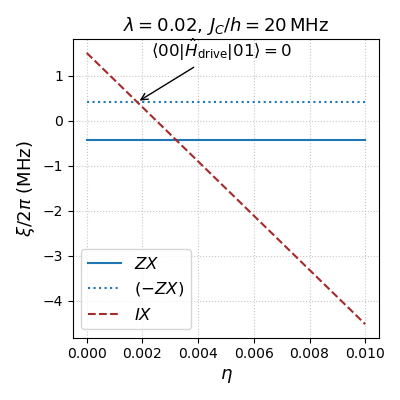

In [276]:


import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Right"]
# FT_Device = params["UMA5"]
FT_Device = params["FTF_FUN10_Type_3"]


k = 120
trunc = 6

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((5, 5), dtype=object)
    for i in range(4):
        for j in range(4):
            index = full_system.dressed_index((i, j))
            ztemp = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j)).overlap(ekets[index])
            np.angle(ztemp)
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

n_F_00_01 = n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_F_10_11 = n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])
n_T_00_01 = n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1])
n_T_10_11 = n_Tr_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1])

eta_values = np.linspace(0, 0.01, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

bare_states_a = Fl1.eigenvals()-Fl1.eigenvals()[0]
bare_states_b = Tr.eigenvals()-Tr.eigenvals()[0]

lambda_ = 0.02
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (np.abs(n_a_bare[0][1]))  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)



for eta in eta_values:
    xi_ZX = f * (n_F_00_01 - n_F_10_11) + eta * f  * (n_T_00_01 - n_T_10_11)
    xi_IX = f * (n_F_00_01 + n_F_10_11) + eta * f * (n_T_00_01 + n_T_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# Convert to numpy arrays for intersection calculation
xi_ZX_neg_arr = np.array(xi_ZX_neg_list)
xi_IX_arr = np.array(xi_IX_list)

# Find intersection index (where sign changes)
diff = xi_ZX_neg_arr - xi_IX_arr
idx_cross = np.where(np.diff(np.sign(diff)))[0]
if len(idx_cross) > 0:
    idx = idx_cross[0]
    # Linear interpolation for better accuracy
    eta1, eta2 = eta_values[idx], eta_values[idx+1]
    y1, y2 = diff[idx], diff[idx+1]
    eta_intersect = eta1 - y1 * (eta2 - eta1) / (y2 - y1)
    xi_intersect = xi_IX_arr[idx] + (xi_IX_arr[idx+1] - xi_IX_arr[idx]) * (eta_intersect - eta1) / (eta2 - eta1)
else:
    eta_intersect = eta_values[0]
    xi_intersect = xi_IX_arr[0]

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(
    rf'$\lambda={lambda_},\,J_C/h={J1T*1e3:.0f}\,\mathrm{{MHz}}$',
    fontsize=13
)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(
    r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$',
    xy=(eta_intersect, xi_intersect),
    xytext=(eta_intersect+0.0005, xi_intersect+1),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12
)
plt.tight_layout()
plt.show()

In [300]:
.0115*65/94/.12


0.0662677304964539